In [1]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 41.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
import time
import stanza

In [3]:
# Download the Estonian model for Stanza
stanza.download("et")
nlp = stanza.Pipeline("et", processors="tokenize,pos,lemma,depparse")

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: et (Estonian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/et/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: et (Estonian):
| Processor | Package      |
----------------------------
| tokenize  | edt          |
| mwt       | edt          |
| pos       | edt_nocharlm |
| lemma     | edt_nocharlm |
| depparse  | edt_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


Example of aspect and opinion terms extraction

In [4]:
start_time = time.time()

text = 'Kõik oli nii hästi läbimõeldud ja teostatud: alates vastuvõtust restorani uksel, kogu menüü ja joogid sinna juurde, väga mõnus jalutuskäik söökikordade keskel, teenindajate suhtlus, atmosfäär…'

doc = nlp(text.lower())

aspect_terms = []
opinion_terms = []

non_aspect_noun_lemmas = ['õhtu', 'kogemus', 'tükk', 'restoran', 'tallinn']
non_opinion_adjective_lemmas = ['soe', 'kuulus']
noun_opinions = ['super', 'ülitore']
sentential_adverbs = ['näiteks', 'sinna', 'juurde']

def collect_subtree_aspect_noun(word, sentence):
    # Recursively assemble a subtree of dependents of an aspect noun
    subtree = [word]
    for child in sentence.words:
        if child.head == word.id and child.deprel == "cop":
          return []
        elif (child.head == word.id and
             child.upos not in ["CCONJ", "PUNCT", "DET", "PRON"] and
             child.feats != "AdpType=Prep" and not
             (child.upos == "NOUN" and child.feats.split("|")[0].split("=")[1] in ["Nom", "Ine"] and child.deprel not in ["nmod", "obj", "obl"] and child.lemma not in non_aspect_noun_lemmas) and
             (child.text not in sentential_adverbs) and not
             ((child.upos == "ADJ" and child.deprel in ["acl", "acl:relcl", "conj", "amod", "root"] and child.lemma not in non_opinion_adjective_lemmas and check_participle_with_noun_dependents(child, sentence) == False) or (child.text in noun_opinions))):
             subtree.extend(collect_subtree_aspect_noun(child, sentence))
    return subtree

def collect_subtree_opinion_verb(word, sentence):
    # Recursively assemble a subtree of dependents of an opinion verb
    subtree = [word]
    for child in sentence.words:
        if child.head == word.id and ((child.deprel == "advmod" and child.text not in sentential_adverbs) or child.deprel in ["obj", "obl", "amod", "conj", "cc"]):
            subtree.extend(collect_subtree_opinion_verb(child, sentence))
    return subtree

def collect_subtree_opinion_noun(word, sentence):
    # Recursively assemble a subtree of dependents of an opinion noun (after a copula)
    subtree = [word]
    for child in sentence.words:
        if child.head == word.id and not (child.upos == "NOUN" and "Nom" in child.feats) and not (child.deprel in ["nsubj:cop", "cop"]):
            subtree.extend(collect_subtree_opinion_noun(child, sentence))
    return subtree

def check_participle_with_noun_dependents(word, sentence):
    # Check if a participle has noun dependents
    has_noun_dependents = False
    for child in sentence.words:
        if child.head == word.id and child.upos == "NOUN" and child.text not in noun_opinions:
          has_noun_dependents = True
    return has_noun_dependents

def has_dependent_copula(word, sentence):
    # Check if a noun has dependent copula
    has_dependent_copula = False
    for child in sentence.words:
        if child.head == word.id and child.deprel == "cop":
          has_dependent_copula = True
    return has_dependent_copula

def collect_subtree_verb_after_sconj(word, sentence):
    # Recursively assemble a subtree of dependents of a verb in a subordinate clause
    subtree = [word]
    for child in sentence.words:
      if child.head == word.id and child.upos != "PUNCT" and child.text != "et":
        subtree.extend(collect_subtree_verb_after_sconj(child, sentence))
    return subtree

for sentence in doc.sentences:
    for i, word in enumerate(sentence.words):
      if word.upos == "NOUN" and word.feats.split("|")[0].split("=")[1] in ["Nom", "Ine", "Ade"] and word.deprel not in ["nmod", "obj", "obl"] and has_dependent_copula(word, sentence) == False and word.lemma not in non_aspect_noun_lemmas:
          subtree_words = collect_subtree_aspect_noun(word, sentence)
          sorted_subtree = sorted(subtree_words, key=lambda w: w.id)
          aspect_terms.append({
                        "text": " ".join([w.text.strip(' ...') for w in sorted_subtree]),
                        "start": sorted_subtree[0].start_char,
                        "end": sorted_subtree[-1].end_char
                    })
      elif word.text == "et":  # subordinate conjunction 'that'
        subtree_words = collect_subtree_verb_after_sconj(sentence.words[word.head - 1], sentence)
        sorted_subtree = sorted(subtree_words, key=lambda w: w.id)
        aspect_terms.append({
                        "text": " ".join([w.text.strip(' ...') for w in sorted_subtree]),
                        "start": sorted_subtree[0].start_char,
                        "end": sorted_subtree[-1].end_char
                    })

    aspect_terms = list(filter(None, aspect_terms))

    if aspect_terms == []:
        opinion_terms = []
        break

    aspect_elems = []
    for elem in aspect_terms:
        aspect_elems.extend(elem["text"].split(" "))

    for i, word in enumerate(sentence.words):
      if word.text in aspect_elems:
        continue
      if word.upos == "VERB" and word.deprel == "root":
        subtree_words = collect_subtree_opinion_verb(word, sentence)
        sorted_subtree = sorted(subtree_words, key=lambda w: w.id)
        opinion_terms.append({
                        "text": " ".join([w.text.strip() for w in sorted_subtree]),
                        "start": sorted_subtree[0].start_char,
                        "end": sorted_subtree[-1].end_char
                    })

    opinion_elems = []
    for elem in opinion_terms:
        opinion_elems.extend(elem["text"].split(" "))

    for i, word in enumerate(sentence.words):
      if word.text in aspect_elems:
        continue
      if word.upos == "NOUN" and (word.text not in aspect_elems) and (word.text not in opinion_elems) and word.deprel == "root":
        subtree_words = collect_subtree_opinion_noun(word, sentence)
        sorted_subtree = sorted(subtree_words, key=lambda w: w.id)
        opinion_terms.append({
                        "text": (" ".join([w.text.strip(' ...') for w in sorted_subtree])).strip(),
                        "start": sorted_subtree[0].start_char,
                        "end": sorted_subtree[-1].end_char
                    })

    for elem in opinion_terms:
      if elem not in opinion_elems:
        opinion_elems.extend(elem["text"].split(" "))

    for i, word in enumerate(sentence.words):
      if word.text in aspect_elems:
        continue
      if word.upos == "ADJ" and (word.text not in opinion_elems) and word.deprel in ["acl", "acl:relcl", "conj", "amod", "root"] and "Case" in word.feats:
        if i > 0 and sentence.words[i - 1].deprel in ["nmod", "advmod"]:
          opinion_terms.append({
                        "text": " ".join([sentence.words[i - 1].text.strip()] + [word.text.strip()]),
                        "start": sentence.words[i - 1].start_char,
                        "end": word.end_char
                    })
        else:
          opinion_terms.append({
                        "text": word.text.strip(),
                        "start": word.start_char,
                        "end": word.end_char
                    })

print("Aspect terms: ", aspect_terms)
print("Opinion terms: ", opinion_terms)

end_time = time.time()
print(f'Time taken for stanza: {end_time - start_time} seconds')

Aspect terms:  [{'text': 'vastuvõtust restorani uksel', 'start': 52, 'end': 79}, {'text': 'menüü', 'start': 86, 'end': 91}, {'text': 'joogid', 'start': 95, 'end': 101}, {'text': 'jalutuskäik söökikordade keskel', 'start': 127, 'end': 158}, {'text': 'teenindajate suhtlus', 'start': 160, 'end': 180}, {'text': 'atmosfäär', 'start': 182, 'end': 191}]
Opinion terms:  [{'text': 'nii hästi läbimõeldud ja teostatud', 'start': 9, 'end': 43}, {'text': 'väga mõnus', 'start': 116, 'end': 126}]
Time taken for stanza: 0.5913057327270508 seconds


In [ ]:
text = 'Kõik oli nii hästi läbimõeldud ja teostatud: alates vastuvõtust restorani uksel, kogu menüü ja joogid sinna juurde, väga mõnus jalutuskäik söökikordade keskel, teenindajate suhtlus, atmosfäär…'
doc = nlp(text.lower())
for sentence in doc.sentences:
    for i, word in enumerate(sentence.words):
      print(word)

{
  "id": 1,
  "text": "kõik",
  "lemma": "kõik",
  "upos": "PRON",
  "xpos": "P",
  "feats": "Case=Nom|Number=Sing|PronType=Tot",
  "head": 5,
  "deprel": "nsubj:cop",
  "start_char": 0,
  "end_char": 4
}
{
  "id": 2,
  "text": "oli",
  "lemma": "olema",
  "upos": "AUX",
  "xpos": "V",
  "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act",
  "head": 5,
  "deprel": "cop",
  "start_char": 5,
  "end_char": 8
}
{
  "id": 3,
  "text": "nii",
  "lemma": "nii",
  "upos": "ADV",
  "xpos": "D",
  "head": 4,
  "deprel": "advmod",
  "start_char": 9,
  "end_char": 12
}
{
  "id": 4,
  "text": "hästi",
  "lemma": "hästi",
  "upos": "ADV",
  "xpos": "D",
  "head": 5,
  "deprel": "advmod",
  "start_char": 13,
  "end_char": 18
}
{
  "id": 5,
  "text": "läbimõeldud",
  "lemma": "läbi_mõeldud",
  "upos": "VERB",
  "xpos": "V",
  "feats": "Tense=Past|VerbForm=Part|Voice=Pass",
  "head": 0,
  "deprel": "root",
  "start_char": 19,
  "end_char": 30
}
{
  "id": 6,
  "text": "ja",
  "le

In [4]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
import re
import unicodedata
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [5]:
# Load EstBERT tokenizer and model
model_name = "tartuNLP/EstBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/410k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [6]:
# Check if a word is punctuation
def is_punctuation(word):
    return bool(re.fullmatch(r"\W+", word))

# Remove accents from a string
def remove_accents(input_str):
    nkfd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nkfd_form if not unicodedata.combining(c)])

# Normalize and lowercase a word for matching
def normalize_word(word):
    return remove_accents(word.lower())

In [7]:
# Extract aspect and opinion terms from a sentence
def extract_aspects_opinions(text):
  doc = nlp(text)

  aspect_terms = []
  opinion_terms = []

  non_aspect_noun_lemmas = ['õhtu', 'kogemus', 'tükk', 'restoran', 'tallinn']
  non_opinion_adjective_lemmas = ['soe', 'kuulus']
  noun_opinions = ['super', 'ülitore']
  sentential_adverbs = ['näiteks', 'sinna', 'juurde']

  def collect_subtree_aspect_noun(word, sentence):
    # Recursively assemble a subtree of dependents of an aspect noun
    subtree = [word]
    for child in sentence.words:
        if child.head == word.id and child.deprel == "cop":
          return []
        elif (child.head == word.id and
             child.upos not in ["CCONJ", "PUNCT", "DET", "PRON"] and
             child.feats != "AdpType=Prep" and not
             (child.upos == "NOUN" and child.feats.split("|")[0].split("=")[1] in ["Nom", "Ine"] and child.deprel not in ["nmod", "obj", "obl"] and child.lemma.lower() not in non_aspect_noun_lemmas) and
             (child.text.lower() not in sentential_adverbs) and not
             ((child.upos == "ADJ" and child.deprel in ["acl", "acl:relcl", "conj", "amod", "root"] and child.lemma.lower() not in non_opinion_adjective_lemmas and check_participle_with_noun_dependents(child, sentence) == False) or (child.text.lower() in noun_opinions))):
             subtree.extend(collect_subtree_aspect_noun(child, sentence))
    return subtree

  def collect_subtree_opinion_verb(word, sentence):
    # Recursively assemble a subtree of dependents of an opinion verb
    subtree = [word]
    for child in sentence.words:
        if child.head == word.id and ((child.deprel == "advmod" and child.text.lower() not in sentential_adverbs) or child.deprel in ["obj", "obl", "amod", "conj", "cc"]):
            subtree.extend(collect_subtree_opinion_verb(child, sentence))
    return subtree

  def collect_subtree_opinion_noun(word, sentence):
    # Recursively assemble a subtree of dependents of an opinion noun (after a copula)
    subtree = [word]
    for child in sentence.words:
        if child.head == word.id and not (child.upos == "NOUN" and "Nom" in child.feats) and not (child.deprel in ["nsubj:cop", "cop"]):
            subtree.extend(collect_subtree_opinion_noun(child, sentence))
    return subtree

  def check_participle_with_noun_dependents(word, sentence):
    # Check if a participle has noun dependents
    has_noun_dependents = False
    for child in sentence.words:
        if child.head == word.id and child.upos == "NOUN" and child.text.lower() not in noun_opinions:
          has_noun_dependents = True
    return has_noun_dependents

  def has_dependent_copula(word, sentence):
    # Check if a noun has dependent copula
    has_dependent_copula = False
    for child in sentence.words:
        if child.head == word.id and child.deprel == "cop":
          has_dependent_copula = True
    return has_dependent_copula

  def collect_subtree_verb_after_sconj(word, sentence):
    # Recursively assemble a subtree of dependents of a verb in a subordinate clause
    subtree = [word]
    for child in sentence.words:
      if child.head == word.id and child.upos != "PUNCT" and child.text != "et":
        subtree.extend(collect_subtree_verb_after_sconj(child, sentence))
    return subtree

  for sentence in doc.sentences:
    for i, word in enumerate(sentence.words):
      if word.upos == "NOUN" and word.feats.split("|")[0].split("=")[1] in ["Nom", "Ine", "Ade"] and word.deprel not in ["nmod", "obj", "obl"] and has_dependent_copula(word, sentence) == False and word.lemma.lower() not in non_aspect_noun_lemmas:
          subtree_words = collect_subtree_aspect_noun(word, sentence)
          sorted_subtree = sorted(subtree_words, key=lambda w: w.id)
          aspect_terms.append({
                        "start": sorted_subtree[0].start_char,
                        "end": sorted_subtree[-1].end_char,
                        "text": " ".join([w.text.strip() for w in sorted_subtree])
                    })
      elif word.text == "et":  # subordinate conjunction 'that'
        subtree_words = collect_subtree_verb_after_sconj(sentence.words[word.head - 1], sentence)
        sorted_subtree = sorted(subtree_words, key=lambda w: w.id)
        aspect_terms.append({
                        "start": sorted_subtree[0].start_char,
                        "end": sorted_subtree[-1].end_char,
                        "text": " ".join([w.text.strip() for w in sorted_subtree])
                    })

    aspect_terms = list(filter(None, aspect_terms))

    if aspect_terms == []:
        opinion_terms = []
        break

    aspect_elems = []
    for elem in aspect_terms:
        aspect_elems.extend(elem["text"].split(" "))

    for i, word in enumerate(sentence.words):
      if word.text in aspect_elems:
        continue
      if word.upos == "VERB" and word.deprel == "root":
        subtree_words = collect_subtree_opinion_verb(word, sentence)
        sorted_subtree = sorted(subtree_words, key=lambda w: w.id)
        opinion_terms.append({
                        "start": sorted_subtree[0].start_char,
                        "end": sorted_subtree[-1].end_char,
                        "text": " ".join([w.text.strip() for w in sorted_subtree])
                    })

    opinion_elems = []
    for elem in opinion_terms:
        opinion_elems.extend(elem["text"].split(" "))

    for i, word in enumerate(sentence.words):
      if word.text in aspect_elems:
        continue
      if word.upos == "NOUN" and (word.text.lower() not in aspect_elems) and (word.text.lower() not in opinion_elems) and word.deprel == "root":
        subtree_words = collect_subtree_opinion_noun(word, sentence)
        sorted_subtree = sorted(subtree_words, key=lambda w: w.id)
        opinion_terms.append({
                        "start": sorted_subtree[0].start_char,
                        "end": sorted_subtree[-1].end_char,
                        "text": (" ".join([w.text.strip(' ...') for w in sorted_subtree])).strip()
                    })

    for elem in opinion_terms:
      if elem not in opinion_elems:
        opinion_elems.extend(elem["text"].split(" "))

    for i, word in enumerate(sentence.words):
      if word.text in aspect_elems:
        continue
      if word.upos == "ADJ" and (word.text.lower() not in opinion_elems) and word.deprel in ["acl", "acl:relcl", "conj", "amod", "root"] and "Case" in word.feats:
        if i > 0 and sentence.words[i - 1].deprel in ["nmod", "advmod"]:
          opinion_terms.append({
                        "start": sentence.words[i - 1].start_char,
                        "end": word.end_char,
                        "text": " ".join([sentence.words[i - 1].text.strip()] + [word.text.strip()])
                    })
        else:
          opinion_terms.append({
                        "start": word.start_char,
                        "end": word.end_char,
                        "text": word.text.strip()
                    })
  return aspect_terms, opinion_terms

In [8]:
# Map tokens to words and aggregate subwords; store both raw and normalized forms
def get_token_word_mapping(tokens):
    word_ids = tokens.word_ids()
    token_labels = tokens.tokens()
    word_to_token_idxs = {}
    word_list = []

    for idx, word_id in enumerate(word_ids):
        if word_id is not None:
            word_to_token_idxs.setdefault(word_id, []).append(idx)

    valid_word_ids = sorted(set([wid for wid in word_ids if wid is not None]))
    for word_id in valid_word_ids:
        token_idxs = word_to_token_idxs[word_id]
        word_tokens = [token_labels[idx] for idx in token_idxs]
        raw_word = "".join([t.replace("##", "") if t.startswith("##") else t for t in word_tokens])
        normalized_word = normalize_word(raw_word)
        if is_punctuation(normalized_word):
            continue
        word_list.append({
            "raw_word": raw_word,
            "word": normalized_word,
            "token_idxs": token_idxs
        })
    return word_list, word_to_token_idxs

In [9]:
# Aggregate attention matrix from tokens to words
def aggregate_attention_by_words(tokens, attention_matrix):
    word_list, word_to_token_idxs = get_token_word_mapping(tokens)
    num_words = len(word_list)
    word_attention_matrix = np.zeros((num_words, num_words))
    for i, word_i in enumerate(word_list):
        idxs_i = word_i['token_idxs']
        for j, word_j in enumerate(word_list):
            idxs_j = word_j['token_idxs']
            sub_scores = [attention_matrix[idx_i, idx_j] for idx_i in idxs_i for idx_j in idxs_j]
            word_attention_matrix[i, j] = np.mean(sub_scores)
    # For visualization, use the raw words
    word_labels = [w['raw_word'] for w in word_list]
    return word_attention_matrix, word_labels

In [10]:
def dynamic_threshold(attention_matrix):
    mean_val = attention_matrix.mean()
    std_val = attention_matrix.std()
    return mean_val + std_val  # Threshold = mean + 1 * std

In [11]:
# Extract attention matrices from the model for a given text
def get_attention_matrices(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens, output_attentions=True)
    attentions = outputs.attentions  # List of attention matrices: [batch_size, heads, tokens, tokens]
    return tokens, attentions

In [12]:
# Aggregate attention from selected layers
def aggregate_layers(attention_list, selected_layers):
    if selected_layers is None or len(selected_layers) == 0:
        raise ValueError("selected_layers must be a non-empty list of layer indices.")

    # Compute average attention across selected layers
    layer_matrices = [attention_list[layer].squeeze(0).mean(dim=0).cpu().numpy() for layer in selected_layers]
    return np.mean(layer_matrices, axis=0)

In [13]:
# Find all valid aspect-opinion pairs based on threshold attention.
# For multi-word opinion terms, if at least one word's attention is >= threshold, the pair is accepted.
def find_aspect_opinion_pairs(tokens, attention_matrix, aspect_terms, opinion_terms, threshold):
    word_list, word_to_token_idxs = get_token_word_mapping(tokens)
    word_attention_matrix, word_labels = aggregate_attention_by_words(tokens, attention_matrix)
    word_label_to_index = {w["word"]: idx for idx, w in enumerate(word_list)}
    normalized_to_raw = {w["word"]: w["raw_word"] for w in word_list}

    aspect_opinion_pairs = []
    for aspect in aspect_terms:
        aspect_words_raw = aspect["text"].split()
        aspect_words = [normalize_word(w) for w in aspect_words_raw]
        aspect_idxs = [word_label_to_index.get(w) for w in aspect_words if word_label_to_index.get(w) is not None]
        if not aspect_idxs:
            continue

        for opinion in opinion_terms:
            opinion_words_raw = opinion["text"].split()
            opinion_words = [normalize_word(w) for w in opinion_words_raw]
            opinion_idxs = [word_label_to_index.get(w) for w in opinion_words if word_label_to_index.get(w) is not None]
            if not opinion_idxs:
                continue

            if any(word_attention_matrix[ai, oi] >= threshold for ai in aspect_idxs for oi in opinion_idxs):
                aspect_opinion_pairs.append({
                    "aspect": {"text": aspect["text"]},
                    "opinion": {"text": opinion["text"]}
                })

    return aspect_opinion_pairs

In [14]:
# Compute sentence embedding (mean pooling over logits)
def compute_sentence_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    hidden_states = outputs.logits
    sentence_embedding = hidden_states.mean(dim=1).squeeze().cpu().numpy()
    return sentence_embedding

In [15]:
# Assign sentiment polarity to opinion terms based on cosine similarity with embeddings of labels
def assign_sentiment_polarity(opinion_terms):
    sentiment_labels = {
        "positive": compute_sentence_embedding("positiivne"),
        "negative": compute_sentence_embedding("negatiivne"),
        "neutral": compute_sentence_embedding("neutraalne")
    }
    opinion_polarities = {}
    for opinion in opinion_terms:
        opinion_embedding = compute_sentence_embedding(opinion["text"])
        best_match = max(sentiment_labels.keys(),
                         key=lambda label: 1 - cosine(opinion_embedding, sentiment_labels[label]))
        opinion_polarities[opinion["text"]] = best_match
    return opinion_polarities

In [16]:
# Plot word-level attention heatmap using raw words for display
def plot_attention_heatmap(attention_matrix, labels):
    plt.figure(figsize=(12, 10))
    sns.heatmap(attention_matrix, xticklabels=labels, yticklabels=labels,
                cmap="Blues", annot=True, fmt=".2f", cbar_kws={"shrink": 0.5})
    plt.title("Word-Level Attention Scores Heatmap")
    plt.xlabel("Words")
    plt.ylabel("Words")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [17]:
# Evaluation: compute aspect accuracy
def evaluate_aspect_accuracy(gold_data, selected_layers, direction='last', window_size=None):
    y_true = []
    y_pred = []
    for item in tqdm(gold_data):
        review_text = item["review_text"]
        gold_aspects = item["aspects"]

        tokens, attentions = get_attention_matrices(review_text)

        if direction == 'last':
            layers = list(range(-selected_layers, 0))
        elif direction == 'first':
            layers = list(range(0, selected_layers))
        elif direction == 'window' and window_size is not None:
            layers = list(range(window_size, window_size + selected_layers))
        else:
            raise ValueError("Invalid direction/window parameters")

        attention_matrix = aggregate_layers(attentions, layers)

        extracted_aspects, extracted_opinions = extract_aspects_opinions(review_text)

        threshold = dynamic_threshold(attention_matrix)
        predicted_pairs = find_aspect_opinion_pairs(tokens, attention_matrix, extracted_aspects, extracted_opinions, threshold)

        gold_aspect_terms = [a["aspect_term"]["text"] for a in gold_aspects]
        print("True aspect terms: ", gold_aspect_terms)
        predicted_aspect_terms = [p["aspect"]["text"] for p in predicted_pairs]
        print("Predicted aspect terms: ", predicted_aspect_terms)

        for aspect in gold_aspect_terms:
            y_true.append(1)
            y_pred.append(1 if aspect in predicted_aspect_terms else 0)

        for aspect in predicted_aspect_terms:
            if aspect not in gold_aspect_terms:
                y_true.append(0)
                y_pred.append(1)

    return accuracy_score(y_true, y_pred)

In [18]:
# Load validation dataset
with open('output_val.json', 'r', encoding='utf-8') as f:
    validation_data = json.load(f)

In [ ]:
# Plot 1: Accuracy by layer index (single layer)
def plot_accuracy_by_single_layer():
    layer_indexes = list(range(len(model.base_model.encoder.layer)))
    accuracies = []
    for i in layer_indexes:
        print(f"Evaluating layer № {i}: ")
        acc = evaluate_aspect_accuracy(validation_data, selected_layers=1, direction='window', window_size=i)
        accuracies.append(acc)

    plt.figure(figsize=(10, 6))
    plt.plot(layer_indexes, accuracies, marker='o')
    plt.title("Accuracy by Single Layer Index")
    plt.xlabel("Layer Index")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

In [ ]:
# Plot 2: Accuracy by number of aggregated layers from last
def plot_accuracy_by_last_layers():
    num_layers = len(model.base_model.encoder.layer)
    aggregated_counts = list(range(1, num_layers + 1))
    accuracies = []
    for count in aggregated_counts:
        print(f"Evaluating {count} last layers: ")
        acc = evaluate_aspect_accuracy(validation_data, selected_layers=count, direction='last')
        accuracies.append(acc)

    plt.figure(figsize=(10, 6))
    plt.plot(aggregated_counts, accuracies, marker='o')
    plt.title("Accuracy by Aggregated Layers (from last)")
    plt.xlabel("Number of Aggregated Layers (from last)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

In [ ]:
# Plot 3: Accuracy by number of aggregated layers from first
def plot_accuracy_by_first_layers():
    num_layers = len(model.base_model.encoder.layer)
    aggregated_counts = list(range(1, num_layers + 1))
    accuracies = []
    for count in aggregated_counts:
        print(f"Evaluating {count} first layers: ")
        acc = evaluate_aspect_accuracy(validation_data, selected_layers=count, direction='first')
        accuracies.append(acc)

    plt.figure(figsize=(10, 6))
    plt.plot(aggregated_counts, accuracies, marker='o')
    plt.title("Accuracy by Aggregated Layers (from first)")
    plt.xlabel("Number of Aggregated Layers (from first)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

In [ ]:
# Plot 4: Accuracy by moving window of 4 layers
def plot_accuracy_by_moving_window():
    num_layers = len(model.base_model.encoder.layer)
    window_size = 4
    window_indexes = list(range(0, num_layers - window_size + 1))
    accuracies = []
    for start_idx in window_indexes:
        print(f"Evaluating layers {start_idx}-{start_idx + 3}: ")
        acc = evaluate_aspect_accuracy(validation_data, selected_layers=window_size, direction='window', window_size=start_idx)
        accuracies.append(acc)

    plt.figure(figsize=(10, 6))
    plt.plot(window_indexes, accuracies, marker='o')
    plt.title(f"Accuracy by Moving Window of {window_size} Layers")
    plt.xlabel("Starting Layer Index of Window")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

Evaluating layer № 0: 


 10%|█         | 1/10 [00:00<00:05,  1.63it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.76it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'toit']


 30%|███       | 3/10 [00:01<00:04,  1.60it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['Toit', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.57it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.42it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['Toit', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:04<00:02,  1.34it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:02,  1.31it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.33it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['külastus', 'teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.47it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht']


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 1: 


 10%|█         | 1/10 [00:00<00:04,  2.10it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.95it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.64it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.80it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 2: 


 10%|█         | 1/10 [00:00<00:04,  2.09it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.98it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit']


 30%|███       | 3/10 [00:01<00:04,  1.69it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.64it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.51it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.35it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.31it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 3: 


 10%|█         | 1/10 [00:00<00:04,  2.10it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.94it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  []


 30%|███       | 3/10 [00:01<00:04,  1.69it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  []


 40%|████      | 4/10 [00:02<00:03,  1.64it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  []


 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.77it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  []


 90%|█████████ | 9/10 [00:05<00:00,  1.81it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  []


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 4: 


 10%|█         | 1/10 [00:00<00:04,  2.15it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.97it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  []


 30%|███       | 3/10 [00:01<00:04,  1.47it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  []


 40%|████      | 4/10 [00:02<00:04,  1.39it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'Toit', 'ruum']


 60%|██████    | 6/10 [00:04<00:03,  1.09it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:05<00:03,  1.01s/it]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:07<00:02,  1.29s/it]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  []


 90%|█████████ | 9/10 [00:08<00:01,  1.26s/it]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht', 'olete']


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 5: 


 10%|█         | 1/10 [00:00<00:04,  2.09it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.93it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'Teenindaja Karl', 'toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'elamusrestoran', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.63it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele']


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.75it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.81it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 6: 


 10%|█         | 1/10 [00:00<00:04,  2.09it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.95it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'Teenindaja Karl', 'toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'elamusrestoran', 'Toit', 'Toit', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.62it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa', 'Pitsa', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.69it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['Toit', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.68it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['külastus', 'teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.52it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 7: 


 10%|█         | 1/10 [00:00<00:06,  1.33it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:06,  1.31it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'toit', 'vein']


 30%|███       | 3/10 [00:02<00:05,  1.37it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:04,  1.44it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.56it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.66it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.76it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.71it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.78it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 8: 


 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.91it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'Toit', 'atmosfäär', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.63it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['põhi', 'Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.72it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'Toit', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.75it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.82it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 9: 


 10%|█         | 1/10 [00:00<00:06,  1.33it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:06,  1.26it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:02<00:06,  1.10it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['atmosfäär']


 40%|████      | 4/10 [00:03<00:04,  1.21it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:04<00:04,  1.24it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:04<00:03,  1.23it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:05<00:02,  1.27it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:06<00:01,  1.23it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:07<00:00,  1.25it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 10: 


 10%|█         | 1/10 [00:00<00:06,  1.36it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:06,  1.26it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  []


 30%|███       | 3/10 [00:02<00:06,  1.10it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:03<00:05,  1.08it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele']


 50%|█████     | 5/10 [00:04<00:04,  1.13it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  []


 60%|██████    | 6/10 [00:05<00:03,  1.08it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:06<00:02,  1.12it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:07<00:01,  1.08it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  []


 90%|█████████ | 9/10 [00:08<00:00,  1.11it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  []


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layer № 11: 


 10%|█         | 1/10 [00:00<00:04,  1.96it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.85it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  []


 30%|███       | 3/10 [00:01<00:04,  1.65it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  []


 40%|████      | 4/10 [00:02<00:03,  1.61it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.69it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik']


 60%|██████    | 6/10 [00:03<00:02,  1.74it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.75it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['külastus']


 90%|█████████ | 9/10 [00:05<00:00,  1.81it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht']


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []


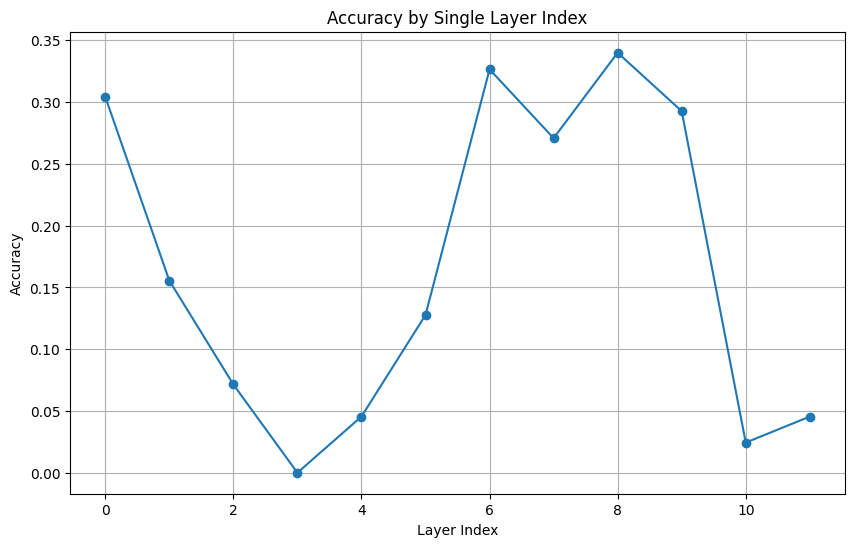

In [ ]:
plot_accuracy_by_single_layer()

Evaluating 1 last layers: 


 10%|█         | 1/10 [00:00<00:06,  1.38it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:05,  1.60it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  []


 30%|███       | 3/10 [00:01<00:04,  1.51it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  []


 40%|████      | 4/10 [00:02<00:03,  1.54it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.64it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik']


 60%|██████    | 6/10 [00:03<00:02,  1.72it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.78it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.72it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['külastus']


 90%|█████████ | 9/10 [00:05<00:00,  1.77it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht']


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 2 last layers: 


 10%|█         | 1/10 [00:00<00:04,  2.08it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.95it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  []


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  []


 40%|████      | 4/10 [00:02<00:03,  1.64it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.72it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  []


 60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  []


 90%|█████████ | 9/10 [00:05<00:00,  1.63it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 3 last layers: 


 10%|█         | 1/10 [00:00<00:06,  1.34it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:06,  1.25it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  []


 30%|███       | 3/10 [00:02<00:05,  1.30it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  []


 40%|████      | 4/10 [00:02<00:04,  1.39it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.54it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:04<00:02,  1.65it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.75it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.70it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  []


 90%|█████████ | 9/10 [00:05<00:00,  1.78it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 4 last layers: 


 10%|█         | 1/10 [00:00<00:04,  2.09it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.96it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['vein']


 30%|███       | 3/10 [00:01<00:04,  1.70it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['atmosfäär', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.65it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.77it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.83it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 5 last layers: 


 10%|█         | 1/10 [00:00<00:05,  1.68it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:05,  1.35it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:02<00:06,  1.12it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['atmosfäär', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:03<00:05,  1.13it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'ruum']


 60%|██████    | 6/10 [00:04<00:02,  1.47it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.60it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.62it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.70it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 6 last layers: 


 10%|█         | 1/10 [00:00<00:04,  2.07it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.92it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.65it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['atmosfäär', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.62it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.77it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.79it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 7 last layers: 


 10%|█         | 1/10 [00:00<00:04,  2.04it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.94it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.40it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:04,  1.25it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:04,  1.23it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:04<00:03,  1.32it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:02,  1.48it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.52it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.63it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 8 last layers: 


 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.94it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.63it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.72it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.80it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 9 last layers: 


 10%|█         | 1/10 [00:00<00:04,  2.12it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.90it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.53it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.40it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:04<00:03,  1.32it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:02,  1.29it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.33it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.47it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 10 last layers: 


 10%|█         | 1/10 [00:00<00:04,  2.10it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.90it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.63it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.61it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.67it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.75it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.81it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 11 last layers: 


 10%|█         | 1/10 [00:00<00:04,  2.05it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.93it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.65it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.58it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:03,  1.66it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.52it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:02,  1.41it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.28it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.29it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 12 last layers: 


 10%|█         | 1/10 [00:00<00:04,  1.98it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.90it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.66it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:04,  1.46it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.57it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.74it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.71it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.76it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []


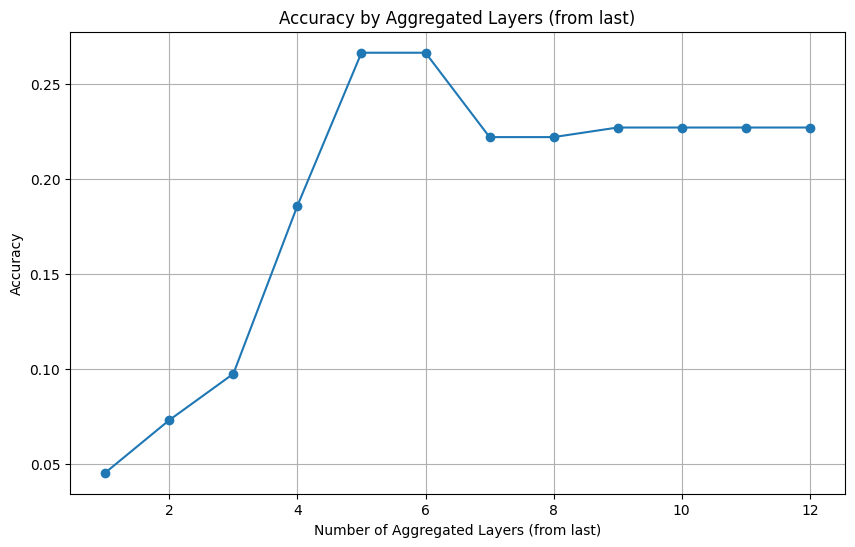

In [ ]:
plot_accuracy_by_last_layers()

Evaluating 1 first layers: 


 10%|█         | 1/10 [00:00<00:04,  1.99it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.90it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'toit']


 30%|███       | 3/10 [00:01<00:04,  1.63it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['Toit', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.59it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.44it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['Toit', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:04<00:02,  1.35it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:02,  1.32it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.28it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['külastus', 'teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.43it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht']


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 2 first layers: 


 10%|█         | 1/10 [00:00<00:04,  2.05it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.88it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.65it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'Toit', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.61it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele']


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['Toit', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.75it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.77it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 3 first layers: 


 10%|█         | 1/10 [00:00<00:04,  1.93it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.89it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.63it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.61it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele']


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.68it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.53it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.34it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.30it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 4 first layers: 


 10%|█         | 1/10 [00:00<00:04,  1.94it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.89it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.64it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.61it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.68it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.72it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.77it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.71it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.78it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 5 first layers: 


 10%|█         | 1/10 [00:00<00:04,  2.11it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.95it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.62it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.74it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.80it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.54it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.42it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 6 first layers: 


 10%|█         | 1/10 [00:00<00:07,  1.24it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:05,  1.52it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:02<00:04,  1.46it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:04,  1.50it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:03<00:03,  1.58it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.77it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.72it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.80it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 7 first layers: 


 10%|█         | 1/10 [00:00<00:04,  2.05it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.97it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.62it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 8 first layers: 


 10%|█         | 1/10 [00:00<00:06,  1.31it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:06,  1.23it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'toit', 'vein']


 30%|███       | 3/10 [00:02<00:05,  1.18it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.46it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:04<00:02,  1.59it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.70it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.67it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.72it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 9 first layers: 


 10%|█         | 1/10 [00:00<00:04,  1.98it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.94it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.64it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.80it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 10 first layers: 


 10%|█         | 1/10 [00:00<00:04,  1.88it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:05,  1.40it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:02<00:06,  1.13it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:03<00:05,  1.11it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.31it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:04<00:02,  1.46it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.60it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.61it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.70it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 11 first layers: 


 10%|█         | 1/10 [00:00<00:04,  2.08it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.94it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.61it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.71it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.73it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.79it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating 12 first layers: 


 10%|█         | 1/10 [00:00<00:04,  2.12it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.95it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.44it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:04,  1.25it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:04,  1.22it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:04<00:03,  1.29it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.49it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.60it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []


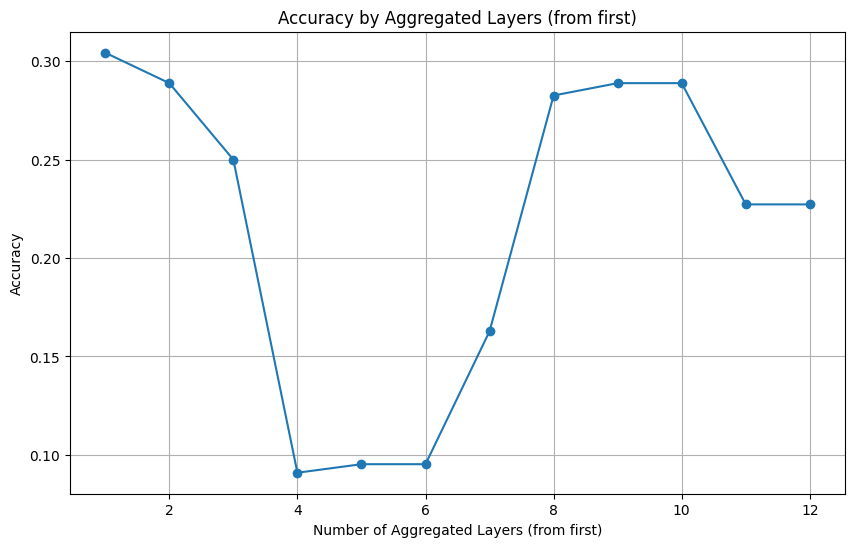

In [ ]:
plot_accuracy_by_first_layers()

Evaluating layers 0-3: 


 10%|█         | 1/10 [00:00<00:04,  2.03it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.95it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.62it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.72it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.85it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.75it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.82it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layers 1-4: 


 10%|█         | 1/10 [00:00<00:04,  1.98it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.74it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.59it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:04,  1.41it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:04<00:03,  1.25it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:05<00:02,  1.30it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.39it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.53it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layers 2-5: 


 10%|█         | 1/10 [00:00<00:04,  2.12it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.93it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit']


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  []


 40%|████      | 4/10 [00:02<00:03,  1.64it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.77it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.82it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layers 3-6: 


 10%|█         | 1/10 [00:00<00:04,  2.02it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.94it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit']


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.63it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  []


 50%|█████     | 5/10 [00:02<00:02,  1.69it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.48it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:02,  1.40it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.29it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:06<00:00,  1.35it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis']


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layers 4-7: 


 10%|█         | 1/10 [00:00<00:04,  2.05it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.93it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.59it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.85it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.77it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.82it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layers 5-8: 


 10%|█         | 1/10 [00:00<00:04,  2.06it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.91it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.66it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'Toit', 'atmosfäär', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.63it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'Toit', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.50it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.41it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layers 6-9: 


 10%|█         | 1/10 [00:00<00:05,  1.50it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  ['noormees']


 20%|██        | 2/10 [00:01<00:04,  1.70it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['lükata oma broneering 18.00st 19.30le', 'toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.60it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'Toit', 'atmosfäär', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.58it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.66it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'Toit', 'ruum', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.73it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.81it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.75it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.79it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'koht', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layers 7-10: 


 10%|█         | 1/10 [00:00<00:04,  2.08it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:04,  1.96it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['toit', 'vein']


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['elamusrestoran', 'atmosfäär', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:02<00:03,  1.63it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:02<00:02,  1.69it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['valik', 'Toit', 'ruum']


 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['teenindus', 'teenindus', 'toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.69it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []
Evaluating layers 8-11: 


 10%|█         | 1/10 [00:00<00:06,  1.37it/s]

True aspect terms:  ['noormees', 'noormees', 'noormees', 'Toit']
Predicted aspect terms:  []


 20%|██        | 2/10 [00:01<00:06,  1.21it/s]

True aspect terms:  ['Teenindaja Karl', 'toit', 'vein']
Predicted aspect terms:  ['vein']


 30%|███       | 3/10 [00:02<00:05,  1.23it/s]

True aspect terms:  ['jahiõhtusöögiga', 'Toit', 'atmosfäär', 'atmosfäär', 'Silverile', 'Sanderile', 'lahkele pererahvale']
Predicted aspect terms:  ['atmosfäär', 'õdus viis novembriõhtu veetmiseks sõprade seltsis']


 40%|████      | 4/10 [00:03<00:04,  1.33it/s]

True aspect terms:  ['Pitsa põhi', 'Portsud ravioolidele', 'Pasta', 'Pitsa', 'Pitsa', 'Jookidel']
Predicted aspect terms:  ['Portsud ravioolidele', 'Pitsa']


 50%|█████     | 5/10 [00:03<00:03,  1.49it/s]

True aspect terms:  ['Toit', 'ruum', 'õhkkond']
Predicted aspect terms:  ['ruum']


 60%|██████    | 6/10 [00:04<00:02,  1.60it/s]

True aspect terms:  ['Tom Khalt', 'supp', 'Kala kogus', 'maitsed']
Predicted aspect terms:  []


 70%|███████   | 7/10 [00:04<00:01,  1.69it/s]

True aspect terms:  ['töötajad']
Predicted aspect terms:  []


 80%|████████  | 8/10 [00:05<00:01,  1.67it/s]

True aspect terms:  ['laua broneerimisest', 'vaatega Kadriorule', 'teenindus', 'teenindus', 'teenindus', 'toidud']
Predicted aspect terms:  ['toidud']


 90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

True aspect terms:  ['kulinaarse "etteastega"']
Predicted aspect terms:  ['üks parimaid restorane Tallinnas vahest ka Baltikumis', 'olete']


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

True aspect terms:  ['toiduvalikut', 'Teenindus', 'Teenindus', 'teenindajad', 'teenindajad']
Predicted aspect terms:  []


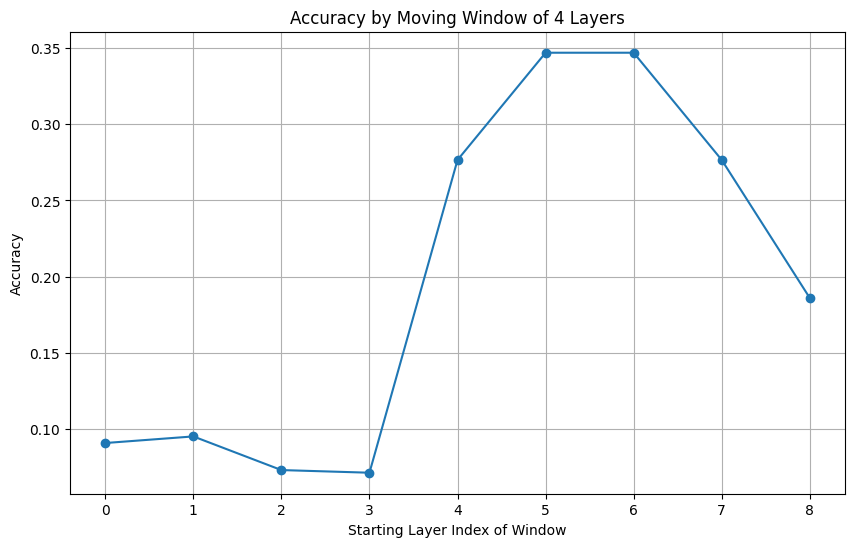

In [ ]:
plot_accuracy_by_moving_window()

In [19]:
# Load annotated test set = gold_data
with open("output_corrected.json", "r", encoding="utf-8") as f:
    gold_data = json.load(f)

# Predict triplets
def predict_triplets_for_dataset(gold_data, selected_layers=4, window_start=5):
    pred_data = []
    for item in tqdm(gold_data):
        review_text = item["review_text"]
        tokens, attentions = get_attention_matrices(review_text)

        layers = list(range(window_start, window_start + selected_layers))
        attention_matrix = aggregate_layers(attentions, layers)

        # Extract aspect and opinion terms
        extracted_aspects, extracted_opinions = extract_aspects_opinions(review_text)

        # Threshold and finding aspect-opinion pairs
        threshold = dynamic_threshold(attention_matrix)
        predicted_pairs = find_aspect_opinion_pairs(tokens, attention_matrix, extracted_aspects, extracted_opinions, threshold)

        # Assinging opinion polarity
        opinion_polarities = assign_sentiment_polarity(extracted_opinions)

        # Сonstructing triplets
        predicted_triplets = []
        for pair in predicted_pairs:
            aspect_text = pair["aspect"]["text"]
            opinion_text = pair["opinion"]["text"]
            polarity = opinion_polarities.get(opinion_text, "neutral")
            predicted_triplets.append({
                "aspect_term": {"text": aspect_text},
                "opinion_term": {"text": opinion_text},
                "polarity": polarity
            })

        pred_data.append({
            "review_text": review_text,
            "triplets": predicted_triplets
        })

    return pred_data

# Getting predictions
predicted_data = predict_triplets_for_dataset(
    gold_data=gold_data,
    selected_layers=4,
    window_start=5
)

  0%|          | 0/100 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


Functions for metrics calculation from metrics_function.ipynb

In [20]:
import typing as T
from typing import List, Dict, Set, Tuple
from collections import defaultdict
import json
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [22]:
def prepare_aspect_set(data: List[Dict]) -> Dict[int, Set[str]]:
    """Prepare sets of aspect terms for each sample."""
    aspect_sets = {}
    for idx, item in enumerate(data):
        triplet_list = item.get("triplets", [])
        aspect_texts = set(
            triplet["aspect_term"]["text"].strip().lower() for triplet in triplet_list
            if "aspect_term" in triplet and "text" in triplet["aspect_term"]
        )
        aspect_sets[idx] = aspect_texts
    return aspect_sets

def prepare_triplet_set(data: List[Dict]) -> Dict[int, Set[Tuple[str, str, str]]]:
    """Prepare sets of (aspect term, opinion term, polarity) triplets for each sample."""
    triplet_sets = {}
    for idx, item in enumerate(data):
        triplet_list = item.get("triplets", [])
        triplets = set(
            (
                triplet["aspect_term"]["text"].strip().lower(),
                triplet["opinion_term"]["text"].strip().lower(),
                triplet["polarity"].lower()
            )
            for triplet in triplet_list
            if all(key in triplet for key in ["aspect_term", "opinion_term", "polarity"])
        )
        triplet_sets[idx] = triplets
    return triplet_sets

def evaluate_triplets(
    gold_data: List[Dict],
    pred_data: List[Dict],
    mode: str = "triplet"
) -> Dict[str, float]:
    """
    Compute precision, recall, F1, and accuracy for aspects or triplets.

    Args:
        gold_data: list of dictionaries with gold aspect/triplet annotations
        pred_data: list of dictionaries with predicted aspect/triplet annotations
        mode: "aspect" to evaluate aspect terms, "triplet" to evaluate full triplets

    Returns:
        A dictionary with precision, recall, F1-score, and accuracy
    """
    assert mode in ["aspect", "triplet"], "Mode must be 'aspect' or 'triplet'"
    assert len(gold_data) == len(pred_data), "Mismatch in number of samples between gold and predictions"

    y_true = []
    y_pred = []

    if mode == "aspect":
        gold_sets = prepare_aspect_set(gold_data)
        pred_sets = prepare_aspect_set(pred_data)
    else:  # mode == "triplet"
        gold_sets = prepare_triplet_set(gold_data)
        pred_sets = prepare_triplet_set(pred_data)

    for idx in range(len(gold_data)):
        gold_review = gold_data[idx].get("review_text", "").strip()
        pred_review = pred_data[idx].get("review_text", "").strip()
        # assert gold_review == pred_review, f"Review text mismatch at index {idx}\nGold review: {gold_review}\nPredicted review: {pred_review}"

        gold_items = gold_sets.get(idx, set())
        pred_items = pred_sets.get(idx, set())

        # True positives
        for item in gold_items:
            y_true.append(1)
            y_pred.append(1 if item in pred_items else 0)

        # False positives
        for item in pred_items:
            if item not in gold_items:
                y_true.append(0)
                y_pred.append(1)

    precision = f'{precision_score(y_true, y_pred, zero_division=0) * 100:.2f}'
    recall = f'{recall_score(y_true, y_pred, zero_division=0) * 100:.2f}'
    f1 = f'{f1_score(y_true, y_pred, zero_division=0) * 100:.2f}'
    accuracy = f'{accuracy_score(y_true, y_pred) * 100:.2f}'

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

Evaluation on a test set

In [28]:
# Triplet-level
metrics = evaluate_triplets(gold_data, predicted_data, mode="triplet")
print("Evaluation (Triplet-level):")
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v}")

Evaluation (Triplet-level):
Precision: 19.72
Recall: 8.48
F1: 11.86
Accuracy: 6.31


In [29]:
# Aspect-level
metrics = evaluate_triplets(gold_data, predicted_data, mode="aspect")
print("Evaluation (Aspect-level):")
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v}")

Evaluation (Aspect-level):
Precision: 52.07
Recall: 23.42
F1: 32.31
Accuracy: 19.27
